In [1]:
import pandas as pd
from matplotlib import colors
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np

# 定义文件路径
file_path = 'vdjdb.txt'  # 将 'your_file.txt' 替换为你的文件路径

# 读取文件内容
with open(file_path, 'r', encoding='utf-8') as file:
    # 读取文件的第一行，获取所有的信息变量名
    header = file.readline().strip().split('\t')
    tcr_data = [dict(zip(header, line.strip().split('\t'))) for line in file]
cdr3_dict = {}
for row in tcr_data:
    complex_id = row['complex.id']
    cdr3 = row['cdr3']
    # Splice together CDR3 with the same complex ID
    if complex_id in cdr3_dict:
        cdr3_dict[complex_id].append(cdr3)
    else:
        cdr3_dict[complex_id] = [cdr3]
# There is a DataFrame containing the TCR sequence
for row in tcr_data:
    complex_id = row['complex.id']
    antigen_epitope = row['antigen.epitope']
    vdjdb_score = row['vdjdb.score']
    # Splice together CDR3 with the same complex ID
    if len(cdr3_dict[complex_id]) == 2:
        cdr3_dict[complex_id].append(antigen_epitope)
        cdr3_dict[complex_id].append(vdjdb_score)
    else:
        continue
cdr3_dict.pop('0')
##Delete unpaired TCRs
df_cdr3 = pd.DataFrame(cdr3_dict)
df_cdr3_trans = df_cdr3.transpose()
names = ['TRA', 'TRB', 'antigen_epitope', 'vdjdb.score']
df_cdr3_trans.columns = names
print(df_cdr3_trans)
##The first step is to read out the paired data

                  TRA                   TRB antigen_epitope vdjdb.score
1       CIVRAPGRADMRF  CASSYLPGQGDHYSNQPQHF        FLKEKGGL           2
2      CAVPSGAGSYQLTF   CASSFEPGQGFYSNQPQHF        FLKEKGGL           2
3         CAVKASGSRLT  CASSYEPGQVSHYSNQPQHF        FLKEKGGL           2
4       CAYRPPGTYKYIF        CASSALASLNEQFF        FLKEKGGL           2
5       CIVRAPGRADMRF  CASSYLPGQGDHYSNQPQHF        FLKEQGGL           2
...               ...                   ...             ...         ...
30590   CMDEGGSNYKLTF         CASSVRSTDTQYF    PQPELPYPQPQL           0
30591     CSLYNNNDMRF         CASSLRYTDTQYF    PQPELPYPQPQL           0
30592   CALSTDSWGKLQF       CASSPGQGGDNEQFF   PQQPFPQPEQPFP           0
30593    CAPQGATNKLIF       CASSLGAGGQETQYF   PQQPFPQPEQPFP           2
30594  CLVGGSGGYNKLIF         CASSSTAQETQYF   PQQPFPQPEQPFP           0

[30594 rows x 4 columns]


In [2]:
df_clean = df_cdr3_trans[df_cdr3_trans['vdjdb.score'] != '0']
#df_clean = df_clean.drop_duplicates()
df_clean = df_clean.reset_index(drop=True)
df_clean['TRA_TRB_Combined'] = df_clean["TRA"] + df_clean["TRB"]
df_clean = df_clean.reset_index(drop=True)
print("There are {} categories of data in the current dataset".format(np.shape(df_clean['antigen_epitope'].unique())))
print(df_clean)

There are (391,) categories of data in the current dataset
                    TRA                   TRB antigen_epitope vdjdb.score  \
0         CIVRAPGRADMRF  CASSYLPGQGDHYSNQPQHF        FLKEKGGL           2   
1        CAVPSGAGSYQLTF   CASSFEPGQGFYSNQPQHF        FLKEKGGL           2   
2           CAVKASGSRLT  CASSYEPGQVSHYSNQPQHF        FLKEKGGL           2   
3         CAYRPPGTYKYIF        CASSALASLNEQFF        FLKEKGGL           2   
4         CIVRAPGRADMRF  CASSYLPGQGDHYSNQPQHF        FLKEQGGL           2   
...                 ...                   ...             ...         ...   
2960         CIALNARLMF         CASSLRATDTQYF    PQPELPYPQPQL           2   
2961   CAMREGRYSSASKIIF       CATSRAGGGGEKLFF    FPQPEQPFPWQP           2   
2962   CLVGDGDGGATNKLIF        CASSQGSGGNEQFF    FPQPEQPFPWQP           2   
2963  CAASVLYGSSNTGKLIF      CASSIVGSGGYNEQFF    QLQPFPQPELPY           2   
2964       CAPQGATNKLIF       CASSLGAGGQETQYF   PQQPFPQPEQPFP           2   

                

In [4]:
##Edit Distance
def ED(str_1, str_2):
    m = len(str_1)
    n = len(str_2)
    # Initializes the dynamic programming matrix with sizes m+1 and n+1 respectively
    Distance = [[0 for _ in range(n + 1)] for _ in range(m + 1)]
    for i in range(n + 1):
        Distance[0][i] = i
    #
    for j in range(m + 1):
        Distance[j][0] = j
    # Initialize the first row and column of the matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            distance_delete = Distance[i - 1][j] + 1
            distance_add = Distance[i][j - 1] + 1
            if str_1[i - 1] == str_2[j - 1]:
                distance_change = Distance[i - 1][j - 1]
            else:
                distance_change = Distance[i - 1][j - 1] + 1
            Distance[i][j] = min(distance_delete, distance_add, distance_change)
    # Count the items from bottom to top
    return Distance[m][n]

In [5]:
Distance_Matrix_TRA = np.zeros((df_clean.shape[0], df_clean.shape[0]))
Distance_Matrix_TRB = np.zeros((df_clean.shape[0], df_clean.shape[0]))
Distance_Matrix_TRAandTRB = np.zeros((df_clean.shape[0], df_clean.shape[0]))
for i in range(df_clean.shape[0]):
    for j in range(df_clean.shape[0]):
        Distance_Matrix_TRA[i][j] = ED(df_clean['TRA'][i], df_clean['TRA'][j])
        Distance_Matrix_TRB[i][j] = ED(df_clean['TRB'][i], df_clean['TRB'][j])
        Distance_Matrix_TRAandTRB[i][j] = ED(df_clean['TRA_TRB_Combined'][i], df_clean['TRA_TRB_Combined'][j])
    if i % 100 == 0:
        print("Currently, {: 2f} TCR3s have been calculated".format(i))

Currently,  0.000000 TCR3s have been calculated
Currently,  100.000000 TCR3s have been calculated
Currently,  200.000000 TCR3s have been calculated
Currently,  300.000000 TCR3s have been calculated
Currently,  400.000000 TCR3s have been calculated
Currently,  500.000000 TCR3s have been calculated
Currently,  600.000000 TCR3s have been calculated
Currently,  700.000000 TCR3s have been calculated
Currently,  800.000000 TCR3s have been calculated
Currently,  900.000000 TCR3s have been calculated
Currently,  1000.000000 TCR3s have been calculated
Currently,  1100.000000 TCR3s have been calculated
Currently,  1200.000000 TCR3s have been calculated
Currently,  1300.000000 TCR3s have been calculated
Currently,  1400.000000 TCR3s have been calculated
Currently,  1500.000000 TCR3s have been calculated
Currently,  1600.000000 TCR3s have been calculated
Currently,  1700.000000 TCR3s have been calculated
Currently,  1800.000000 TCR3s have been calculated
Currently,  1900.000000 TCR3s have been cal

In [7]:
# TODO block 3
from sklearn.decomposition import PCA
import time
pca = PCA(n_components=50)
time_start = time.time()
pca_result = pca.fit_transform(Distance_Matrix_TRA)


print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
print ('TRA Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

PCA done! Time elapsed: 39.79838848114014 seconds
TRA Variance explained per principal component: [0.29274852 0.15991532 0.09536731 0.08323397 0.04261621 0.03329607
 0.02653336 0.0236708  0.01935635 0.01722937 0.0155295  0.01396139
 0.0124197  0.01124593 0.01064576 0.00886528 0.00773778 0.00718799
 0.00655583 0.00602351 0.00512334 0.00477361 0.00428047 0.00416744
 0.00386571 0.00342747 0.00316868 0.00295737 0.00277255 0.00255309
 0.00231668 0.00226002 0.0022279  0.00203526 0.00191807 0.00186214
 0.00176721 0.00173331 0.00148157 0.00133073 0.00128038 0.00122683
 0.00114809 0.0010984  0.00103746 0.00099698 0.0009372  0.00089753
 0.00083297 0.00079509]


In [9]:
sum(pca.explained_variance_ratio_)

0.9604134738191739

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# 在PCA结果上执行t-SNE变换
start_time = time.time()
X_tsne = tsne.fit_transform(pca_result)
end_time = time.time()

# 打印t-SNE执行时间
print("t-SNE执行时间:", end_time - start_time, "秒")

t-SNE执行时间: 11.818991899490356 秒


In [11]:
##Next, calculate the effectiveness of the algorithm
unique_antigen_epitopes = df_clean['antigen_epitope'].unique()
# Create a dictionary corresponding to a category
label_mapping = {antigen_epitope: idx for idx, antigen_epitope in enumerate(unique_antigen_epitopes, start=0)}

# Create a list of real categories
true_labels = [label_mapping[epitope] for epitope in df_clean['antigen_epitope']]

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-38.82867, 19.307638, '0'),
  Text(-39.090405, -0.5004412, '1'),
  Text(-39.09041, -0.50063574, '2'),
  Text(-39.09042, -0.50051636, '3'),
  Text(-16.620028, 0.2334582, '4'),
  Text(-4.149178, -49.19349, '5'),
  Text(-19.714252, 1.757905, '6'),
  Text(3.3158321, 27.095852, '7'),
  Text(-9.550697, -41.942562, '8'),
  Text(1.7273998, -5.448779, '9'),
  Text(-16.413086, 14.635202, '10'),
  Text(-8.785303, -4.8953385, '11'),
  Text(0.7361179, 20.123259, '12'),
  Text(26.436438, -1.3114947, '13'),
  Text(-5.1772323, -34.311462, '14'),
  Text(45.22837, -22.1931, '15'),
  Text(0.21155739, -21.717808, '16'),
  Text(-34.39232, -3.2295535, '17'),
  Text(10.041591, 11.084486, '18'),
  Text(7.501769, -58.18425, '19'),
  Text(-34.393353, -3.2296617, '20'),
  Text(45.228317, -22.193098, '21'),
  Text(50.91605, -18.566734, '22'),
  Text(26.351881, -0.9671005, '23'),
  Text(26.978968, -0.81735384, '24'),
  Text(26.978968, -0.81735384, '25'),


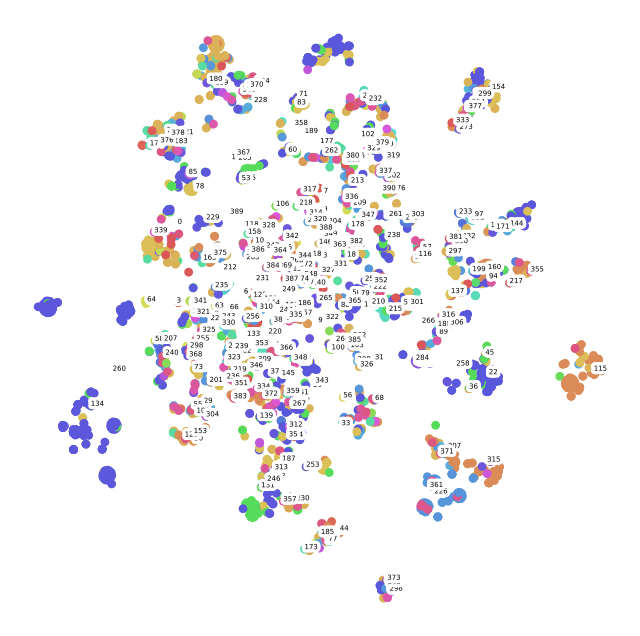

In [12]:
import fashion_scatter as fs
colors_array = np.array(true_labels)
fs.fashion_scatter(X_tsne,colors_array)

In [13]:
from sklearn.decomposition import PCA
import time
pca = PCA(n_components=50)
time_start = time.time()
pca_result = pca.fit_transform(Distance_Matrix_TRB)


print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
print ('TRA Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

PCA done! Time elapsed: 39.44899845123291 seconds
TRA Variance explained per principal component: [0.43492315 0.13575414 0.08802709 0.057873   0.03988582 0.03261532
 0.02817848 0.01930411 0.01728282 0.01198923 0.00936841 0.00836071
 0.00680195 0.00647454 0.00635505 0.0051271  0.00464079 0.00414748
 0.00381238 0.00343664 0.00330422 0.00265324 0.00257052 0.00232162
 0.00214983 0.00211278 0.00198565 0.00180884 0.00164338 0.00152434
 0.00143769 0.0014132  0.00137249 0.00125669 0.00123288 0.00115926
 0.00103454 0.0010111  0.00097117 0.00088105 0.00086346 0.00079592
 0.00077911 0.00075639 0.00072664 0.00068265 0.00065379 0.00063607
 0.00059326 0.00056437]


In [14]:
sum(pca.explained_variance_ratio_)

0.9652543735473381

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# 在PCA结果上执行t-SNE变换
start_time = time.time()
X_tsne = tsne.fit_transform(pca_result)
end_time = time.time()

# 打印t-SNE执行时间
print("t-SNE执行时间:", end_time - start_time, "秒")

t-SNE执行时间: 10.565806150436401 秒


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:>,
 [Text(7.1845536, 3.4004388, '0'),
  Text(6.7862477, 3.8181386, '1'),
  Text(6.638335, 3.9516194, '2'),
  Text(6.7720795, 3.8326771, '3'),
  Text(17.919792, -4.387165, '4'),
  Text(-51.161545, -10.746293, '5'),
  Text(-39.050102, 12.330284, '6'),
  Text(33.634697, -3.3977947, '7'),
  Text(60.557716, -0.3912359, '8'),
  Text(-9.705906, 13.553265, '9'),
  Text(5.9932966, 6.67098, '10'),
  Text(22.939825, 19.901878, '11'),
  Text(-53.062073, 32.18723, '12'),
  Text(-15.575555, 21.670006, '13'),
  Text(66.744965, -3.1873846, '14'),
  Text(-5.274, 19.018867, '15'),
  Text(-19.818377, 51.273586, '16'),
  Text(-14.678059, -23.958609, '17'),
  Text(5.367434, 9.540846, '18'),
  Text(-57.648304, 18.967405, '19'),
  Text(-15.079317, -24.067059, '20'),
  Text(-5.273972, 19.018787, '21'),
  Text(-42.550148, 37.10231, '22'),
  Text(-16.460161, 23.14843, '23'),
  Text(-15.47075, 22.882286, '24'),
  Text(-16.088299, 22.66216, '25'),
  Text(-38.30479

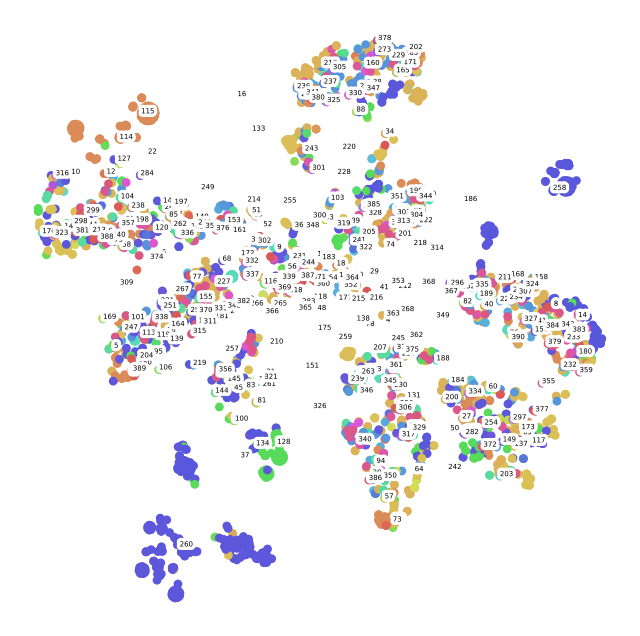

In [16]:
import fashion_scatter as fs
colors_array = np.array(true_labels)
fs.fashion_scatter(X_tsne,colors_array)

In [17]:
pca = PCA(n_components=50)
time_start = time.time()
pca_result = pca.fit_transform(Distance_Matrix_TRAandTRB)


print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))
print ('TRA Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

PCA done! Time elapsed: 40.422173500061035 seconds
TRA Variance explained per principal component: [0.35232354 0.11144272 0.07440476 0.05206186 0.04525395 0.03749336
 0.02820488 0.02232071 0.017433   0.01643566 0.01502284 0.01430991
 0.01213762 0.01123248 0.00994196 0.00938252 0.00795845 0.00767192
 0.00676957 0.0062478  0.00554939 0.00522318 0.0049503  0.00448881
 0.00439315 0.00413147 0.0038835  0.00353613 0.00344408 0.00320444
 0.00303024 0.00287882 0.00263859 0.00254556 0.00250755 0.00232696
 0.00218212 0.0021     0.00200659 0.00189711 0.00173313 0.00168319
 0.00164416 0.00154098 0.00151534 0.00142196 0.00140819 0.001313
 0.00124286 0.00122924]


In [18]:
sum(pca.explained_variance_ratio_)

0.9396995373846869

In [19]:
tsne = TSNE(random_state=42)
# 在PCA结果上执行t-SNE变换
start_time = time.time()
X_tsne = tsne.fit_transform(pca_result)
end_time = time.time()

# 打印t-SNE执行时间
print("t-SNE执行时间:", end_time - start_time, "秒")

t-SNE执行时间: 12.74360179901123 秒


(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:>,
 [Text(22.585823, 50.952934, '0'),
  Text(21.748032, 57.885353, '1'),
  Text(21.747759, 57.886658, '2'),
  Text(21.748138, 57.886265, '3'),
  Text(9.790938, 5.249744, '4'),
  Text(-16.413208, 3.0389483, '5'),
  Text(-26.77066, 4.842636, '6'),
  Text(8.345351, 3.3210437, '7'),
  Text(11.533432, -27.490494, '8'),
  Text(2.838517, 33.538834, '9'),
  Text(9.272236, 1.567383, '10'),
  Text(-4.940178, 23.538757, '11'),
  Text(-15.20947, -29.925173, '12'),
  Text(-1.8779082, 5.7443457, '13'),
  Text(14.514813, -30.585184, '14'),
  Text(18.428423, 33.81983, '15'),
  Text(-17.681494, 13.628725, '16'),
  Text(-49.386982, -3.270718, '17'),
  Text(11.715012, 48.495163, '18'),
  Text(5.2288404, -1.7512174, '19'),
  Text(-49.386982, -3.270718, '20'),
  Text(18.428413, 33.81893, '21'),
  Text(14.75878, -62.285076, '22'),
  Text(-1.0402315, 5.003698, '23'),
  Text(-1.0402315, 5.003698, '24'),
  Text(-1.0402315, 5.003698, '25'),
  Text(-3.8212051, -2

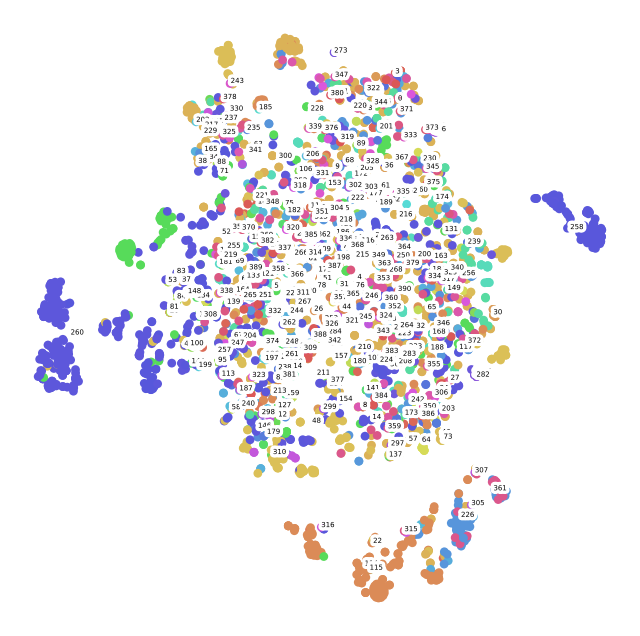

In [20]:
import fashion_scatter as fs
colors_array = np.array(true_labels)
fs.fashion_scatter(X_tsne,colors_array)